In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

torch:  1.8 ; cuda:  cu111
detectron2: 0.6


Config 'configs/BAText/CTW1500/attn_R_50.yaml' has no VERSION. Assuming it to be compatible with latest v2.
The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


/home/dinhco/Pictures/Screenshot from 2022-11-22 23-40-30.png: detected 12 instances in 2.62s
[[[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [29 29 29]
  [29 29 29]
  [29 29 29]]

 [[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [29 29 29]
  [29 29 29]
  [29 29 29]]

 [[29 29 29]
  [29 29 29]
  [29 29 29]
  ...
  [29 29 29]
  [29 29 29]
  [29 29 29]]

 ...

 [[15 15 23]
  [15 15 23]
  [15 15 23]
  ...
  [15 15 23]
  [15 15 23]
  [15 15 23]]

 [[15 15 23]
  [15 15 23]
  [15 15 23]
  ...
  [15 15 23]
  [15 15 23]
  [15 15 23]]

 [[15 15 23]
  [15 15 23]
  [15 15 23]
  ...
  [15 15 23]
  [15 15 23]
  [15 15 23]]]
['Browre fites', 'Makessureypuurmage sin-POPRNGTormalt.', 'Acnwtee', 'M866- with Srreannit', 'upnoad imsgg', "coople Ghonne '", 'ABCNet for Text Detection', 'TN9 1172 2840', 'wificerg wonteh tonghthins. toopgadye eatercomeereettert', 'F 1 0 0 0 belhosson', 'Dragand Grop Tiereee', 'Limn 200We perfffee. PRC PRNS']
tensor([[34., 82., 79.,  ..., 96., 96., 96.],
        [45., 65., 75., 

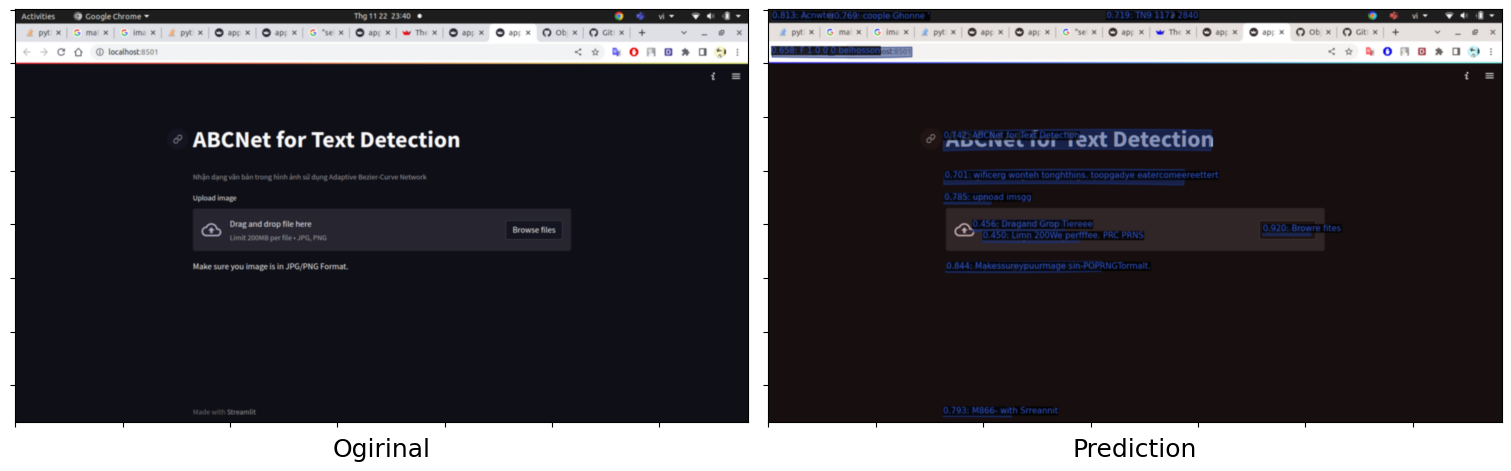

In [1]:
import os
import cv2
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from adet.config import get_cfg
from IPython.display import Image
from demo.predictor import VisualizationDemo
from adet.utils.visualizer import TextVisualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.data.detection_utils import read_image

def show_img_result(img1_path, img2_path):
    plt.figure(constrained_layout=True, figsize=(15, 15))

    img1 = cv2.cvtColor(cv2.imread(img1_path, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_xlabel('Ogirinal', fontsize=18)
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.imshow(img1, interpolation='bicubic')

    ax2 = plt.subplot(1, 2, 2)
    img2 = cv2.cvtColor(cv2.imread(img2_path, cv2.COLOR_BGR2RGB), cv2.COLOR_BGR2RGB)
    ax2.set_xlabel('Prediction', fontsize=18)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.imshow(img2, interpolation='bicubic')

def decode_recognition(vis, rec):
    s = ''
    for c in rec:
        c = int(c)
        if c < vis.voc_size - 1:
            if vis.voc_size == 96:
                s += vis.CTLABELS[c]
            else:
                s += str(chr(vis.CTLABELS[c]))
        elif c == vis.voc_size -1:
            s += u'口'
    return s

def setup_cfg(config_file, opts, confidence_threshold=0.5):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(config_file)
    cfg.merge_from_list(opts)

    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold
    cfg.MODEL.FCOS.INFERENCE_TH_TEST = confidence_threshold
    cfg.MODEL.MEInst.INFERENCE_TH_TEST = confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = confidence_threshold
    cfg.MODEL.DEVICE = 'cpu'
    cfg.freeze()
    return cfg

img_path = "/home/dinhco/Pictures/Screenshot from 2022-11-22 23-40-30.png"
output_path = "img_output"

config_file = 'configs/BAText/CTW1500/attn_R_50.yaml'
opts = ['MODEL.WEIGHTS', 'ctw1500_attn_R_50.pth']
confidence_threshold = 0.5

cfg = setup_cfg(config_file, opts, confidence_threshold)
demo = VisualizationDemo(cfg)
img = read_image(img_path, format="BGR")
start_time = time.time()
predictions, visualized_output = demo.run_on_image(img)
print(f"{img_path}: detected {len(predictions['instances'])} instances in {time.time() - start_time:.2f}s")
out_filename = os.path.join(output_path, os.path.basename(img_path))

metadata = MetadataCatalog.get(cfg.DATASETS.TEST[0] if len(cfg.DATASETS.TEST) else "__unused")
instance_mode = ColorMode.IMAGE
visualizer = TextVisualizer(img, metadata, instance_mode=instance_mode, cfg=cfg)

if "instances" in predictions:
    instances = predictions["instances"].to(torch.device("cpu"))
    pred_texts = [decode_recognition(visualizer, rec) for rec in instances.recs]
    vis_output = visualizer.draw_instance_predictions(predictions=instances)
    img_output = vis_output.get_image()[:, :, ::-1]
    vis_output.save(out_filename)

    print(img_output)
    print(pred_texts)
    print(predictions["instances"].recs)
    print(predictions["instances"].scores)
    print(predictions['instances'].pred_boxes)
    print(predictions['instances'].pred_classes)
    print(predictions["instances"].beziers)

show_img_result(img_path, out_filename)
# display(Image(filename=out_filename))

In [ ]:
# Detect on single image
!python demo/demo.py \
        --config-file configs/BAText/CTW1500/attn_R_50.yaml \
        --input sample_images/text_curve.jpg \
        --output img_output \
        --opts MODEL.WEIGHTS ctw1500_attn_R_50.pth

In [ ]:
# Detect on folder image
!python demo/demo.py \
        --config-file configs/BAText/CTW1500/attn_R_50.yaml \
        --input sample_images \
        --output img_output \
        --opts MODEL.WEIGHTS ctw1500_attn_R_50.pth

In [ ]:
# Detect on folder images
!python demo/demo.py \
        --config-file configs/BAText/CTW1500/attn_R_50.yaml \
        --input-video videoplayback.mp4 \
        --output img_output \
        --opts MODEL.WEIGHTS ctw1500_attn_R_50.pth

In [ ]:
# Detect on webcam
!python demo/demo.py \
        --config-file configs/BAText/CTW1500/attn_R_50.yaml \
        --webcam \
        --confidence-threshold 0.5 \
        --opts MODEL.WEIGHTS ctw1500_attn_R_50.pth